In [1]:
from langchain_together import ChatTogether
from dotenv import load_dotenv, find_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated, Optional
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
)
from langgraph.prebuilt import create_react_agent
from decouple import config
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_cohere.sql_agent.agent import create_sql_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.output_parsers.string import StrOutputParser

In [2]:
load_dotenv(find_dotenv())

True

# Database

In [3]:
from langchain_community.utilities import SQLDatabase

DB_URL=config("DB_URL")
db = SQLDatabase.from_uri(DB_URL)
print(db.dialect)
print(db.get_usable_table_names())

/home/data4i0/Dev/sch-rag-01/.venv/lib/python3.12/site-packages/langchain_community/utilities/sql_database.py:123: SAWarning: Did not recognize type 'vector' of column 'embedding'
  self._metadata.reflect(


postgresql
['account_emailaddress', 'account_emailconfirmation', 'auth_group', 'auth_group_permissions', 'auth_permission', 'authentication_user', 'authentication_user_groups', 'authentication_user_user_permissions', 'authtoken_token', 'chats_chatgroupmessages', 'chats_chatmessages', 'chats_chatrooms', 'chats_groupchatrooms', 'chats_groupchatrooms_admin', 'chats_groupchatrooms_members', 'community_commnunitymessagecomments', 'community_commnunitymessagecomments_likes', 'community_community', 'community_community_members', 'community_communitycategory', 'community_communitymessages', 'community_communitymessages_likes', 'community_partner_communitypartner', 'community_partner_communitypartnerdemorequest', 'community_partner_communitypartnerinterventionmember', 'community_partner_communitypartnerquote', 'community_partner_communitypartnerrole', 'community_partner_communitypartnerschool', 'community_partner_communitypartnerstudentinterventionlog', 'community_partner_communitypartnerstuden

# Schemas

In [4]:
class PermissionSchema(BaseModel):
    """
    Schema for determining whether a user input is permitted.
    
    Attributes:
        permitted (bool): Indicates whether the input is allowed. 
                          - True: The input is permitted.
                          - False: The input is not permitted.
    """
    permitted: Literal[True, False] = Field(False, descripiton = "Indicates whether the user input is allowed.")

class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

class QueryFormulationSchema(BaseModel):
    """
    Schema for generating an SQL query that retrieves the answer to a user input.
    
    Attributes:
        sql_query (str): The SQL query formulated based on the user's request. 
                         - This query should be executable on the target database.
                         - It should be structured to return the relevant data answering the user's input.
                         - If the query cannot be formulated, this field may be None.
    """
    sql_query: Optional[str] = Field(None, description = "The generated SQL query that corresponds to the user's input.")

class QueryAnswerSchema(BaseModel):
    """
    Schema for generating an answer based on the user's input and the retrieved database results.

    Attributes:
        answer (str): The final response generated using the user's input and the query results.
                      - This answer should be meaningful and relevant to the user's request.
                      - If no relevant data is found, this field may contain an appropriate message.
    """
    answer: str = Field(description="The response generated from the database query and the user's input.")

# Models

In [5]:
llm = ChatTogether(
    model="meta-llama/Llama-3.3-70b-Instruct-Turbo",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Structured Models

In [6]:
permission_llm = llm.with_structured_output(PermissionSchema)

In [7]:
verification_llm = llm.with_structured_output(CheckRelevance)

In [8]:
qf_llm = llm.with_structured_output(QueryFormulationSchema)

In [9]:
qa_llm = llm.with_structured_output(QueryAnswerSchema)

In [10]:
llm

ChatTogether(client=<openai.resources.chat.completions.completions.Completions object at 0x77c7e6c131d0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x77c7e78a4080>, model_name='meta-llama/Llama-3.3-70b-Instruct-Turbo', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), max_retries=2, together_api_key=SecretStr('**********'), together_api_base='https://api.together.xyz/v1/')

In [11]:
verification_llm

RunnableBinding(bound=ChatTogether(client=<openai.resources.chat.completions.completions.Completions object at 0x77c7e6c131d0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x77c7e78a4080>, model_name='meta-llama/Llama-3.3-70b-Instruct-Turbo', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), max_retries=2, together_api_key=SecretStr('**********'), together_api_base='https://api.together.xyz/v1/'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'CheckRelevance', 'description': '', 'parameters': {'properties': {'relevance': {'description': "Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'.", 'type': 'string'}}, 'required': ['relevance'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': <class '__main__.CheckRelevance'>}, 'parallel_tool_calls': False, 'tool_choice': {'type': 'function', 'function': {'name': '

# Tools

In [12]:
list_sql_database_tool = ListSQLDatabaseTool(db=db)
info_sql_database_tool_description = (
    "Input to this tool is a comma-separated list of tables, output is the "
    "schema and sample rows for those tables. "
    "Be sure that the tables actually exist by calling "
    f"{list_sql_database_tool.name} first! "
    "Example Input: table1, table2, table3"
)
info_sql_database_tool = InfoSQLDatabaseTool(
    db=db, description=info_sql_database_tool_description
)
query_sql_database_tool_description = (
    "Input to this tool is a detailed and correct SQL query, output is a "
    "result from the database. If the query is not correct, an error message "
    "will be returned. If an error is returned, rewrite the query, check the "
    "query, and try again. If you encounter an issue with Unknown column "
    f"'xxxx' in 'field list', use {info_sql_database_tool.name} "
    "to query the correct table fields."
)
query_sql_database_tool = QuerySQLDatabaseTool(
    db=db, description=query_sql_database_tool_description
)
query_sql_checker_tool_description = (
    "Use this tool to double check if your query is correct before executing "
    "it. Always use this tool before executing a query with "
    f"{query_sql_database_tool.name}!"
)
query_sql_checker_tool = QuerySQLCheckerTool(
    db=db, llm=llm, description=query_sql_checker_tool_description
)

In [13]:
permission_tools = [info_sql_database_tool, list_sql_database_tool]
relevance_tools = [info_sql_database_tool, list_sql_database_tool]
qf_tools = [info_sql_database_tool, list_sql_database_tool, query_sql_checker_tool]

# State

In [14]:
class InputState(TypedDict):
    question: str

In [15]:
class OutputState(TypedDict):
    answer: str

In [16]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    question: str
    permitted: bool
    relevant: bool
    decision: str
    sql_query: str
    sql_error: str
    raw_answer: str
    answer: str

# Nodes

In [17]:
question = "Names of students in lincoln school?"

In [152]:
async def query_permission_node(state: InputState) -> State:
    return {"permitted": True}

In [153]:
async def query_relevant_node(state: State):
    system = """You are an assistant that determines whether a given question is related to the following {dialect} database schema.
    Get the table names that are related to the question from the tool ListSQLDatabaseTool
    Then get the schema for the table names from the tool InfoSQLDatabaseTool
    
    Respond with only "relevant" or "not_relevant".
    """
    prompt_template = PromptTemplate.from_template(system)
    relevance_system_message = prompt_template.format(dialect=db.dialect)
    agent = create_react_agent(llm, relevance_tools, prompt=SystemMessage(relevance_system_message))
    is_relevant_invoke = agent.invoke(
        {"messages": [{"role": "user", "content": state['question']}]},
    )
    print(is_relevant_invoke['messages'][-1].content)
    if is_relevant_invoke['messages'][-1].content == "relevant":
        return {"relevant": True} 
    return {"relevant": False}

In [154]:
async def query_decision_node(state: State):
    """A decision node to decide if a user input is permitted or not."""
    print(state['permitted'])
    print(state['relevant'])
    decision = state['permitted'] and state['relevant']
    print(decision)
    if decision:
        return {"decision": "input permitted"}
    return {"decision": "input not permitted"}

In [176]:
async def sql_query_formulation_node(state: State):
    if state.get("sql_error"):
        system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:
        Get the table names that are related to the question from the tool ListSQLDatabaseTool
        Then get the schema for the table names from the tool InfoSQLDatabaseTool
        
        Provide only the {dialect} SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.
        
        For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.

        If it asks for a list only return the first 5

        You had a previous SQL error: {sql_error}, for this query: {sql_query}, ensure the new query corrects the issue.
        """
        
        prompt_template = PromptTemplate.from_template(system)
        qf_system_message = prompt_template.format(dialect=db, sql_error = state.get("sql_error"), sql_query=state.get("sql_query"))
        agent = create_react_agent(llm, relevance_tools, prompt=SystemMessage(qf_system_message), response_format=QueryFormulationSchema)
        qf_invoke = agent.invoke(
            {"messages": [{"role": "user", "content": state['question']}]},
        )
    else:
        system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:
        Get the table names that are related to the question from the tool ListSQLDatabaseTool
        Then get the schema for the table names from the tool InfoSQLDatabaseTool
        
        Provide only the {dialect} SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.
        
        For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.

        If it asks for a list only return the first 5
        """
        
        prompt_template = PromptTemplate.from_template(system)
        qf_system_message = prompt_template.format(dialect=db)
        agent = create_react_agent(llm, relevance_tools, prompt=SystemMessage(qf_system_message), response_format=QueryFormulationSchema)
        qf_invoke = agent.invoke(
            {"messages": [{"role": "user", "content": state['question']}]},
        )
        
    return {"sql_query": qf_invoke["messages"][-1].content}

In [190]:
async def sql_query_node(state: State):
    try:
        print(state['sql_query'])
        answer = db.run(state['sql_query'])
        print(answer)
        return {"raw_answer": answer, "sql_error": ""}  # Clear previous errors if successful
    except Exception as e:
        return {"sql_error": str(e)}

In [191]:
async def route_sql_error(state: State):
    if state.get("sql_error"):
        return "sql_query_formulation_node"  # Retry query formulation if there's an error
    return "query_answer_node"

In [192]:
async def query_answer_node(state: State) -> OutputState:
    prompt = """
    You are an assistant that converts answers from an sql query to a natural language answer while also using the user question:
    The question is {question}
    The sql answer is {answer}

    Reply with only a natural language answer for the user in a friendly manner.
    """
    prompt_template = PromptTemplate.from_template(prompt)
    chain = prompt_template | llm | StrOutputParser()
    answer = chain.invoke({
        "question": state['question'],
        "answer": state["raw_answer"]
    })

    print(answer)
    return {"answer": answer}

In [193]:
async def route_decision(state: State):
    print(state['decision'])
    if state['decision'] == "input permitted":
        return "sql_query_formulation_node"
    else:
        return "end"

In [194]:
async def update_output(state: State):
    return {"output": "Your question is not relevant or not permitted."}

# Graph

In [195]:
workflow = StateGraph(State, input=InputState, output=OutputState)

In [196]:
workflow.add_node("query_permission_node", query_permission_node)
workflow.add_node("query_relevant_node", query_relevant_node)
workflow.add_node("query_decision_node", query_decision_node)
workflow.add_node("sql_query_formulation_node", sql_query_formulation_node)
workflow.add_node("sql_query_node", sql_query_node)
workflow.add_node("query_answer_node", query_answer_node)
workflow.add_node("update_output", update_output)

In [197]:
workflow.add_edge(START, "query_permission_node")
workflow.add_edge(START, "query_relevant_node")
workflow.add_edge("query_permission_node", "query_decision_node")
workflow.add_edge("query_relevant_node", "query_decision_node")
workflow.add_conditional_edges(
    "query_decision_node", 
    route_decision, 
    {
        "sql_query_formulation_node": "sql_query_formulation_node",
        "end": "update_output"
    }
)
workflow.add_edge("sql_query_formulation_node", "sql_query_node")
workflow.add_conditional_edges(
    "sql_query_node", 
    route_sql_error, 
    {
        "sql_query_formulation_node": "sql_query_formulation_node",  # Retry on error
        "query_answer_node": "query_answer_node"  # Proceed if successful
    }
)
workflow.add_edge("update_output", END)
workflow.add_edge("query_answer_node", END)

In [198]:
checkpoint = MemorySaver()

In [199]:
graph = workflow.compile(checkpointer=checkpoint)

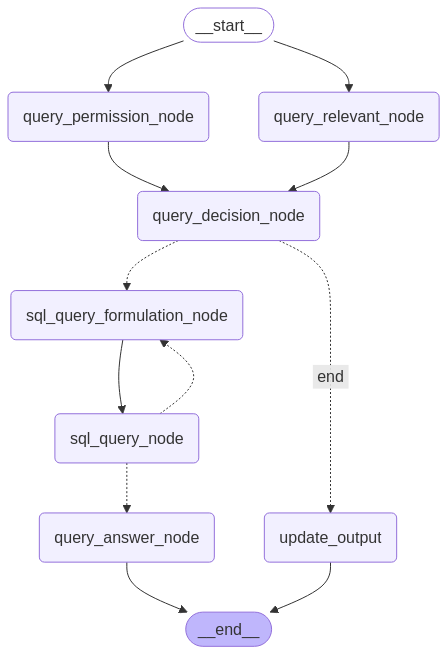

In [200]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [203]:
answer = await graph.ainvoke(input={"question": "Give me the student names in Dawson High"}, config={"thread_id": "123"})

relevant
True
True
True
input permitted
SELECT T1.student_unique_id AS student_name FROM school_schoolstudent AS T1 INNER JOIN school_school AS T2 ON T1.school_id = T2.id WHERE T2.name = 'Dawson High' LIMIT 5
[('S001',), ('S002',), ('S003',), ('S004',), ('S005',)]
The students in Dawson High are S001, S002, S003, S004, and S005.


In [204]:
print(answer['answer'])

The students in Dawson High are S001, S002, S003, S004, and S005.
